In [21]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

import SessionTools.two_photon as st2p
from pingouin import mixed_anova, pairwise_tests

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EL_jGCaMP7b_TBHRNAi')

sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_meetings/EL_jGCaMP7b_TBHRNAi/')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) & (sess_df['dark']==0))]

Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [3]:
sess_df.head()

,date,fly,sess,fictrac_scan_num,closed_loop,dark,rnai_line,gal4_line,usable,fictrac_dat_file,notes,fly_id
0,08_04_2024,fly1,closed_loop-000,0.0,1,0,control,ELDR009,1,fictrac-20240408_104747.dat,NaN,08_04_2024_fly1_ELDR009_control
1,08_04_2024,fly1,dark-001,1.0,0,1,control,ELDR009,1,fictrac-20240408_104747.dat,NaN,08_04_2024_fly1_ELDR009_control
2,08_04_2024,fly1,closed_loop-002,2.0,2,0,control,ELDR009,1,fictrac-20240408_104747.dat,NaN,08_04_2024_fly1_ELDR009_control
3,08_04_2024,fly1,dark-003,3.0,0,2,control,ELDR009,1,fictrac-20240408_104747.dat,NaN,08_04_2024_fly1_ELDR009_control
5,08_04_2024,fly2,closed_loop-002,2.0,1,0,control,ELDR009,1,fictrac-20240408_120523.dat,NaN,08_04_2024_fly2_ELDR009_control


### Generate summary plots and statistics for offset variance


In [4]:
# make pandas dataframe for each session

stats_df = {'fly_id': [],
           'cl': [],
           'rnai': [],
            'dark': [],
           'offset_var':[],
           'offset_var_nomask': []}


for _,row in sess_df.iterrows():
    if row['usable']==1 and row['gal4_line']!='control':
        outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # dff = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)[-1, :, :] -1
        dff = pp.calculate_zscored_F('rois', zscore=True, exp_detrend = True)[-1, :, :] 
        # note smoothing conditions
        dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(dff, 1, axis=-1),.5,axis=0, mode='wrap')
        
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        h_mask = np.abs(heading)> np.pi/4 # excluding 90 degrees directly behind the fly
        
        
        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0)) # vector average
        rho, phi = np.roll(rho,-2), np.roll(phi,-2)
        # rho - population vector magnitude
        # phi - population vector angle
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        
        
        stats_df['fly_id'].append(row['fly_id'])
        stats_df['cl'].append(row['closed_loop'])
        stats_df['dark'].append(row['dark'])
        stats_df['rnai'].append(row['rnai_line '])
        
        
        stats_df['offset_var'].append(sp.stats.circvar(offset[h_mask]))
        stats_df['offset_var_nomask'].append(sp.stats.circvar(offset))

stats_df = pd.DataFrame.from_dict(stats_df)

In [5]:
#reduce to one entry per condition per fly by averaging
stats_df_unique = {'fly_id': [],
           'cl': [],
           'rnai': [],
            'dark': [],
           'offset_var':[],
            'offset_var_logit':[],
           }

fly_ids = stats_df['fly_id'].unique()
for r, fly in enumerate(fly_ids):
    
    cl_mask = (stats_df['fly_id']==fly)*(stats_df['cl']>1) # closed_loop ==1 is the very first experience in closed loop
                                                           # closed_loop >1 takes data where fly has at least 10 min of 
                                                           # experience prior to imaging
    dark_mask = (stats_df['fly_id']==fly)*(stats_df['dark']>=1) 
    if (cl_mask.sum()>0) and (dark_mask.sum()>0): # take only flies with both closed loop and dark data
        
        rnai = stats_df['rnai'].loc[cl_mask]
        
        cl = stats_df['offset_var'].loc[cl_mask].mean() #average across sessions

        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(1)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['dark'].append(0)
        stats_df_unique['offset_var'].append(cl)
        stats_df_unique['offset_var_logit'].append(sp.special.logit(cl)) # logit transform for mixed effects model below
    
    
        dark = stats_df['offset_var'].loc[dark_mask].mean() # average across flies
        
        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(0)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['dark'].append(1)
        stats_df_unique['offset_var'].append(dark)
        stats_df_unique['offset_var_logit'].append(sp.special.logit(dark)) # logit tranform for mixed effect model below
        
stats_df_unique = pd.DataFrame.from_dict(stats_df_unique)

In [6]:
# reformat for plotting only
stats_df_plot = {'fly_id': [],
                 'rnai': [],
                 'offset_var_dark':[],
                 'offset_var_closed_loop':[],
                }
fly_ids = stats_df_unique['fly_id'].unique()
for fly in fly_ids:
    stats_df_plot['fly_id'].append(fly)
    
    fly_mask = stats_df_unique['fly_id']==fly
    
    _df = stats_df_unique.loc[fly_mask]
    stats_df_plot['rnai'].append(_df['rnai'].iloc[0])
    
    _df_d = _df.loc[_df['dark']==1]
    stats_df_plot['offset_var_dark'].append(_df_d['offset_var'])
    
    _df_cl = _df.loc[_df['dark']==0]
    stats_df_plot['offset_var_closed_loop'].append(_df_cl['offset_var'])
stats_df_plot = pd.DataFrame.from_dict(stats_df_plot)

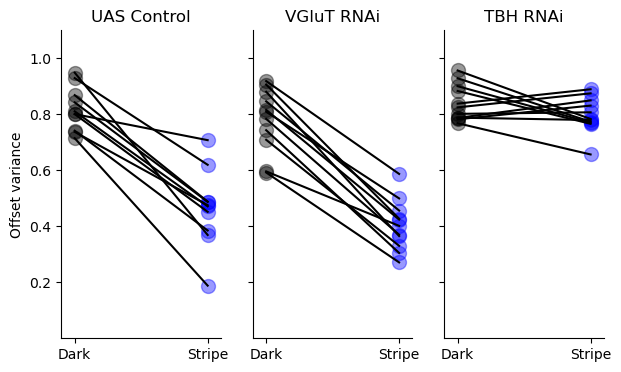

In [7]:
fig,ax = plt.subplots(1,3,sharey=True, figsize=[7,4])

c_df = stats_df_plot.loc[stats_df_plot['rnai']=='control']
ax[0].set_title('UAS Control')
ax[0].plot([0,1], c_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[0].scatter(np.zeros((c_df.shape[0],)), c_df['offset_var_dark'], color='black', alpha=.4, s=100)
ax[0].scatter(np.ones((c_df.shape[0],)), c_df['offset_var_closed_loop'], color='blue', alpha=.4, s=100)

vglut_df = stats_df_plot.loc[stats_df_plot['rnai']=='vglut_rnai']
ax[1].set_title('VGluT RNAi')
ax[1].plot([0,1], vglut_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[1].scatter(np.zeros((vglut_df.shape[0],)), vglut_df['offset_var_dark'], color='black', alpha=.4, s=100)
ax[1].scatter(np.ones((vglut_df.shape[0],)), vglut_df['offset_var_closed_loop'], color='blue', alpha=.4, s=100)

tbh_df = stats_df_plot.loc[stats_df_plot['rnai']=='rnai_67968']
ax[2].set_title('TBH RNAi')
ax[2].plot([0,1], tbh_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[2].scatter(np.zeros((tbh_df.shape[0],)), tbh_df['offset_var_dark'], color='black', alpha=.4, s=100)
ax[2].scatter(np.ones((tbh_df.shape[0],)), tbh_df['offset_var_closed_loop'], color='blue', alpha=.4, s=100)


for _ax in ax:
    _ax.set_ylim([0.0,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset variance')


fig.savefig(figfolder / 'offset_var_summary.pdf', format='pdf')

In [8]:
df = stats_df_unique.loc[stats_df_unique['rnai']!='vacht_rnai'] # excluding VAchT data since there's only 2 flies

# fit linear mixed effects
# genotype and dark vs closed loop are categorical fixed effects
# fly id is random effect intercepts
# "control" genotype and dark are considered the baseline conditions for the main effects

model = mixedlm('offset_var_logit ~ C(rnai, Treatment("control"))*C(dark, Treatment(1))', df, groups=df['fly_id'])

result = model.fit()
print(result.summary())
print(result.pvalues)

                                      Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  offset_var_logit
No. Observations:                  64                       Method:                              REML            
No. Groups:                        32                       Scale:                               0.2470          
Min. group size:                   2                        Log-Likelihood:                      -56.1920        
Max. group size:                   2                        Converged:                           Yes             
Mean group size:                   2.0                                                                           
-----------------------------------------------------------------------------------------------------------------
                                                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------

Shapiro-Wilk Test p-value: 0.20155492424964905


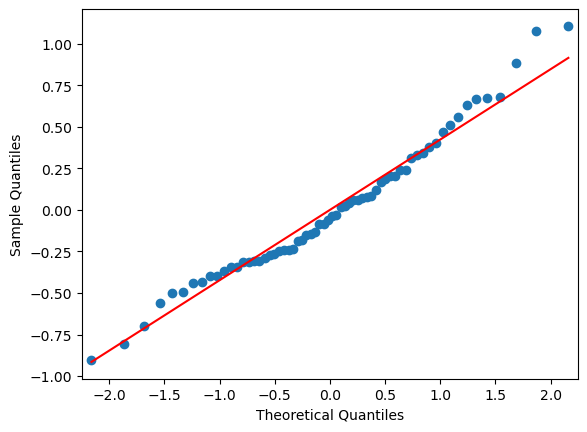

In [9]:
## QQ plots for normality assumptions
sm.qqplot(result.resid, line="s")

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p_value = sp.stats.shapiro(result.resid)
print(f"Shapiro-Wilk Test p-value: {shapiro_p_value}")

### Compare bump amplitude vs speed for all flies

In [10]:
180/np.pi*.25

14.32394487827058

In [11]:
# dh_bins = np.linspace(.1, 3., num=8)
dh_bins = np.linspace(.0, 3.5, num=20)
stats_df = {'fly_id': [],
           'cl': [],
           'rnai': [],
           'dark': [],
           'rho_dig': [],
           # 'bamp_dig':[],
           }

for _,row in sess_df.iterrows():
    if row['usable']==1 and row['gal4_line']!='control':
        outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        volume_times = np.array(pp.metadata['frame_times'])[:,0]
        dt = (volume_times[1:]-volume_times[:-1]).mean()
        
        dff = pp.calculate_zscored_F('rois', zscore=True, exp_detrend = True)[-1, :, :] 
        dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(dff, 1, axis=-1),.5,axis=0, mode='wrap')
        bamp = np.amax(dff,axis=0)-np.amin(dff,axis=0)
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        x_h, y_h = st2p.utilities.pol2cart(np.ones(heading.shape),heading)
        _, heading_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(x_h,1), sp.ndimage.gaussian_filter1d(y_h,1))
        
        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
        rho, phi = np.roll(rho,-2), np.roll(phi,-2)
        
        dh = np.diff(np.unwrap(heading_sm))/dt
        dh = np.concatenate([[0],dh])
        mask_dh = (np.abs(dh)<3.9) * (np.abs(dh)>0.2)
        
        
        
        dh_dig = np.digitize(np.abs(dh[mask_dh]), dh_bins) - 1

        rho_dig = np.array([rho[mask_dh][dh_dig == i].mean() for i in range(len(dh_bins) - 1)])
        nan_mask = np.isnan(rho_dig)
        rho_dig = sp.interpolate.interp1d(dh_bins[:-1][~nan_mask], rho_dig[~nan_mask], kind='linear', bounds_error=False)(dh_bins)
        
        # bamp_dig = np.array([bamp[mask_dh][dh_dig == i].mean() for i in range(len(dh_bins) - 1)])
        # nan_mask = np.isnan(bamp_dig)
        # bamp_dig = sp.interpolate.interp1d(dh_bins[:-1][~nan_mask], bamp_dig[~nan_mask], kind='linear', bounds_error=False)(dh_bins)
        
        
        stats_df['fly_id'].append(row['fly_id'])
        stats_df['cl'].append(row['closed_loop'])
        stats_df['dark'].append(row['dark'])
        stats_df['rnai'].append(row['rnai_line '])
        stats_df['rho_dig'].append(rho_dig)
        # stats_df['bamp_dig'].append(bamp_dig)
stats_df = pd.DataFrame.from_dict(stats_df)
       

/tmp/ipykernel_3390708/2062545021.py:39: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([rho[mask_dh][dh_dig == i].mean() for i in range(len(dh_bins) - 1)])
/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3390708/2062545021.py:39: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([rho[mask_dh][dh_dig == i].mean() for i in range(len(dh_bins) - 1)])
/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3390708/2062545021.py:39: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([rho[mask_dh][dh_dig == i].mean() for i in range(len(dh_bins) - 1)])
/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/numpy/core/_methods.py:192: Runtime

In [12]:
stats_df.head()

,fly_id,cl,rnai,dark,rho_dig
0,08_04_2024_fly1_ELDR009_control,1,control,0,"[nan, 0.5576078219668859, 0.5739623274413039, ..."
1,08_04_2024_fly1_ELDR009_control,0,control,1,"[nan, 0.5589647494037765, 0.5486733549261659, ..."
2,08_04_2024_fly1_ELDR009_control,2,control,0,"[nan, 0.5188288001306345, 0.5822016593389899, ..."
3,08_04_2024_fly1_ELDR009_control,0,control,2,"[nan, 0.45048824295375556, 0.4586955798066771,..."
4,08_04_2024_fly2_ELDR009_control,1,control,0,"[nan, 0.4830546469833097, 0.4718860222958123, ..."


In [13]:
stats_df = stats_df.loc[stats_df['cl']!=1] # exclude first closed loop session
stats_df.loc[stats_df['cl']>=1, 'cl'] = 1 #
stats_df.loc[stats_df['dark']>=1, 'dark'] = 1 # 
stats_df = stats_df.loc[stats_df['rnai']!='vacht_rnai']
grouped = stats_df.groupby(['fly_id','dark','rnai'])['rho_dig'].apply(lambda x: np.nanmean(np.stack(x),axis=0))
# grouped = stats_df.groupby(['fly_id','dark','rnai'])['bamp_dig'].apply(lambda x: np.nanmean(np.stack(x),axis=0))
grouped = grouped.reset_index()

grouped.head()





/tmp/ipykernel_3390708/1528286441.py:5: RuntimeWarning: Mean of empty slice
  grouped = stats_df.groupby(['fly_id','dark','rnai'])['rho_dig'].apply(lambda x: np.nanmean(np.stack(x),axis=0))


,fly_id,dark,rnai,rho_dig
0,03_06_2024_fly1_ELDR009_vglut_rnai,0,vglut_rnai,"[nan, 0.5596453200562763, 0.5935961989588708, ..."
1,03_06_2024_fly1_ELDR009_vglut_rnai,1,vglut_rnai,"[nan, 0.3811077887184343, 0.42152969920166167,..."
2,03_06_2024_fly2_ELDR009_vglut_rnai,0,vglut_rnai,"[nan, 0.45344596231393364, 0.45038416034329043..."
3,03_06_2024_fly2_ELDR009_vglut_rnai,1,vglut_rnai,"[nan, 0.34021730942635836, 0.3566516049810165,..."
4,03_06_2024_fly4_ELDR009_vglut_rnai,0,vglut_rnai,"[nan, 0.3977261251976812, 0.4209203766533204, ..."


control
vglut_rnai
rnai_67968


/tmp/ipykernel_3390708/173155300.py:30: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['control']['cl_rho'],axis=0), sp.stats.sem(rho_dict['control']['cl_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/173155300.py:35: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['vglut_rnai']['cl_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['cl_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/173155300.py:40: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['rnai_67968']['cl_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/173155300.py:46: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['control']['dark_rho'],axis=0), sp.stats.sem(rho_dict['control']['dark_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/173155300.py:51: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['vglut_rnai']['dark_rho'],axis=0), sp.stats.sem(rho_d

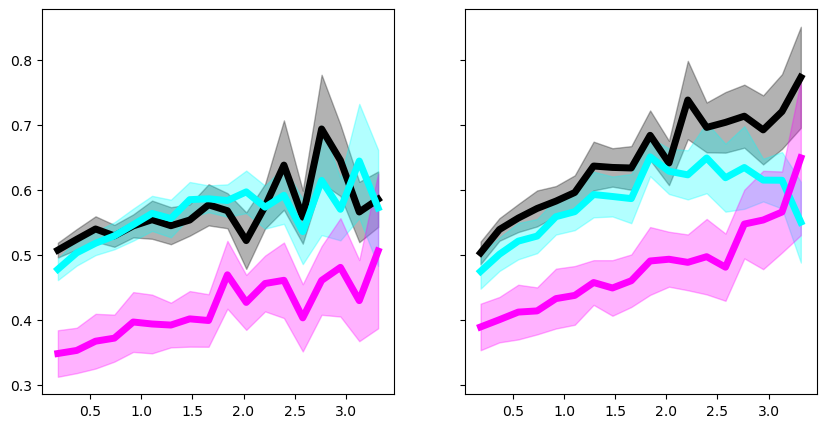

In [16]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2
conditions = ('control','vglut_rnai', 'rnai_67968') 
rho_dict = {}
for cond in conditions:
    rho_dict[cond] = {'dark_rho':[],
                      'cl_rho':[]}

for fly in grouped['fly_id'].unique():
    if (grouped['fly_id']==fly).sum()>1:
        # print(grouped.loc[grouped['fly_id']==fly])
    
        
        cond = grouped.loc[grouped['fly_id']==fly,'rnai'].iloc[0]
        
        dark_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==1), 'rho_dig']
        cl_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==0), 'rho_dig']
        # dark_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==1), 'bamp_dig']
        # cl_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==0), 'bamp_dig']
        
        rho_dict[cond]['dark_rho'].append(dark_rho.iloc[0])
        rho_dict[cond]['cl_rho'].append(cl_rho.iloc[0])

for cond in conditions:
    print(cond)
    rho_dict[cond]['dark_rho'] = np.stack(rho_dict[cond]['dark_rho'])
    rho_dict[cond]['cl_rho'] = np.stack(rho_dict[cond]['cl_rho'])


fig, ax= plt.subplots(1,2, figsize=[10,5], sharey=True)
mu,sem = np.nanmean(rho_dict['control']['cl_rho'],axis=0), sp.stats.sem(rho_dict['control']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bins, mu, color='black', linewidth=5)
ax[0].fill_between(dh_bins, mu-sem, mu+sem, color='black', alpha=.3)
# ax[0].plot(dh_bins, rho_dict['control']['cl_rho'].T, alpha=.3, color='black')

mu,sem = np.nanmean(rho_dict['vglut_rnai']['cl_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bins, mu, color='cyan', linewidth=5)
ax[0].fill_between(dh_bins, mu-sem, mu+sem, color='cyan', alpha=.3)
# ax[0].plot(dh_bins, rho_dict['vglut_rnai']['cl_rho'].T, alpha=.3, color='cyan')

mu,sem = np.nanmean(rho_dict['rnai_67968']['cl_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bins, mu, color='magenta', linewidth=5)
ax[0].fill_between(dh_bins, mu-sem, mu+sem, color='magenta', alpha=.3)
# ax[0].plot(dh_bins, rho_dict['rnai_67968']['cl_rho'].T, alpha=.3, color='magenta')


mu,sem = np.nanmean(rho_dict['control']['dark_rho'],axis=0), sp.stats.sem(rho_dict['control']['dark_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bins, mu, color='black', linewidth=5)
ax[1].fill_between(dh_bins, mu-sem, mu+sem, color='black', alpha=.3)
# ax[1].plot(dh_bins, rho_dict['control']['dark_rho'].T, alpha=.3, color='black')

mu,sem = np.nanmean(rho_dict['vglut_rnai']['dark_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['dark_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bins, mu, color='cyan', linewidth=5)
ax[1].fill_between(dh_bins, mu-sem, mu+sem, color='cyan', alpha=.3)
# ax[1].plot(dh_bins, rho_dict['vglut_rnai']['dark_rho'].T, alpha=.3, color='cyan')

mu,sem = np.nanmean(rho_dict['rnai_67968']['dark_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bins, mu, color='magenta', linewidth=5)
ax[1].fill_between(dh_bins, mu-sem, mu+sem, color='magenta', alpha=.3)
# ax[1].plot(dh_bins, rho_dict['rnai_67968']['dark_rho'].T, alpha=.3, color='magenta')


/tmp/ipykernel_3390708/4093544101.py:2: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['control']['cl_rho'],axis=0), sp.stats.sem(rho_dict['control']['cl_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/4093544101.py:6: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['control']['dark_rho'],axis=0), sp.stats.sem(rho_dict['control']['dark_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/4093544101.py:10: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['vglut_rnai']['cl_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['cl_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/4093544101.py:14: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['vglut_rnai']['dark_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['dark_rho'],axis=0,nan_policy='omit')
/tmp/ipykernel_3390708/4093544101.py:18: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(rho_dict['rnai_67968']['cl_rho'],axis=0), sp.stats.sem(

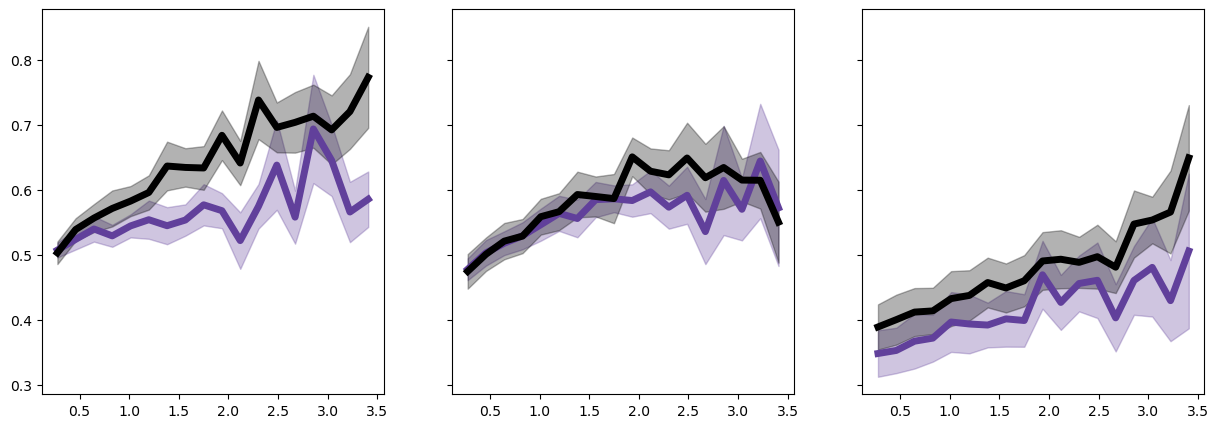

In [17]:
fig, ax= plt.subplots(1,3, figsize=[15,5], sharey=True)
mu,sem = np.nanmean(rho_dict['control']['cl_rho'],axis=0), sp.stats.sem(rho_dict['control']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color=plt.cm.Purples(.8), linewidth=5, label='UAS control')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Purples(.8), alpha=.3)

mu,sem = np.nanmean(rho_dict['control']['dark_rho'],axis=0), sp.stats.sem(rho_dict['control']['dark_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='black', linewidth=5, label='UAS control')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)

mu,sem = np.nanmean(rho_dict['vglut_rnai']['cl_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['cl_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color=plt.cm.Purples(.8), linewidth=5, label='UAS control')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Purples(.8), alpha=.3)

mu,sem = np.nanmean(rho_dict['vglut_rnai']['dark_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['dark_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='black', linewidth=5, label='UAS control')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)

mu,sem = np.nanmean(rho_dict['rnai_67968']['cl_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
ax[2].plot(dh_bin_centers, mu, color=plt.cm.Purples(.8), linewidth=5, label='UAS control')
ax[2].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Purples(.8), alpha=.3)

mu,sem = np.nanmean(rho_dict['rnai_67968']['dark_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['dark_rho'],axis=0,nan_policy='omit')
ax[2].plot(dh_bin_centers, mu, color='black', linewidth=5, label='UAS control')
ax[2].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


In [18]:
h,p = sp.stats.kruskal(np.nanmean(rho_dict['control']['cl_rho'],axis=-1), 
                       np.nanmean(rho_dict['vglut_rnai']['cl_rho'],axis=-1),
                            np.nanmean(rho_dict['rnai_67968']['cl_rho'], axis=-1))
print(h,p)

t,p = sp.stats.mannwhitneyu(np.nanmean(rho_dict['control']['cl_rho'],axis=-1), 
                            np.nanmean(rho_dict['rnai_67968']['cl_rho'], axis=-1))
print(t,p)

t,p = sp.stats.mannwhitneyu(np.nanmean(rho_dict['vglut_rnai']['cl_rho'],axis=-1), 
                            np.nanmean(rho_dict['rnai_67968']['cl_rho'], axis=-1))
print(t,p)


9.257851239669435 0.00976524505398014
92.0 0.010162438913637686
100.0 0.010439075899985918


In [19]:
# reformat for regression

reg_df = {'fly_id': [],
           'rnai': [],
           'dark': [],
           'rho': [],
           'dh': [],
           }
for _, row in grouped.iterrows():
    # print(row)
    for i, dh in enumerate(dh_bins):
        rho = row['rho_dig'][i]
        if ~np.isnan(rho):
            reg_df['fly_id'].append(row['fly_id'])
            reg_df['rnai'].append(row['rnai'])
            reg_df['dark'].append(row['dark'])
            reg_df['rho'].append(sp.special.logit(rho))
            reg_df['dh'].append(dh)
    

reg_df = pd.DataFrame.from_dict(reg_df)

reg_df.reset_index()

reg_df.head()
# reg_df.shape

,fly_id,rnai,dark,rho,dh
0,03_06_2024_fly1_ELDR009_vglut_rnai,vglut_rnai,0,0.239723,0.184211
1,03_06_2024_fly1_ELDR009_vglut_rnai,vglut_rnai,0,0.378852,0.368421
2,03_06_2024_fly1_ELDR009_vglut_rnai,vglut_rnai,0,0.304070,0.552632
3,03_06_2024_fly1_ELDR009_vglut_rnai,vglut_rnai,0,0.471148,0.736842
4,03_06_2024_fly1_ELDR009_vglut_rnai,vglut_rnai,0,0.788977,0.921053


In [22]:
tt = pairwise_tests(dv='rho', between='rnai',
                   subject='fly_id', within='dark', data=reg_df,
                   padjust='holm', parametric=True, interaction=True, within_first=False)

tt

/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/pingouin/pairwise.py:585: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a 

,Contrast,rnai,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,rnai,-,control,rnai_67968,False,True,3.706354,14.102234,two-sided,0.002321,0.006964,holm,21.881,1.503491
1,rnai,-,control,vglut_rnai,False,True,0.883315,18.113024,two-sided,0.388640,0.388640,holm,0.516,0.364672
2,rnai,-,rnai_67968,vglut_rnai,False,True,-2.895964,20.000000,two-sided,0.008934,0.017868,holm,5.617,-1.187950
3,dark,-,0,1,True,True,-2.951133,31.000000,two-sided,0.005984,NaN,NaN,6.831,-0.405362
4,rnai * dark,control,0,1,True,True,-2.261897,9.000000,two-sided,0.050021,0.100043,holm,1.762,-0.951094
5,rnai * dark,rnai_67968,0,1,True,True,-2.541831,10.000000,two-sided,0.029271,0.087813,holm,2.579,-0.459066
6,rnai * dark,vglut_rnai,0,1,True,True,-0.454515,10.000000,two-sided,0.659165,0.659165,holm,0.325,-0.138145


In [17]:
import statsmodels.formula.api as smf
model = smf.ols(formula='rho ~ dh*C(rnai,Treatment("control"))', data=reg_df.loc[reg_df['dark']==0])

result = model.fit()
print(result.summary())
print(result.pvalues)

                            OLS Regression Results                            
Dep. Variable:                    rho   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     31.69
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           2.14e-28
Time:                        11:19:10   Log-Likelihood:                -494.11
No. Observations:                 557   AIC:                             1000.
Df Residuals:                     551   BIC:                             1026.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [18]:

model = smf.ols(formula='rho ~ dh*C(rnai,Treatment("control"))', data=reg_df.loc[reg_df['dark']==1])

result = model.fit()
print(result.summary())
print(result.pvalues)

                            OLS Regression Results                            
Dep. Variable:                    rho   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     29.07
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           1.80e-26
Time:                        11:19:13   Log-Likelihood:                -618.71
No. Observations:                 611   AIC:                             1249.
Df Residuals:                     605   BIC:                             1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Shapiro-Wilk Test p-value: 2.7436118812027755e-21


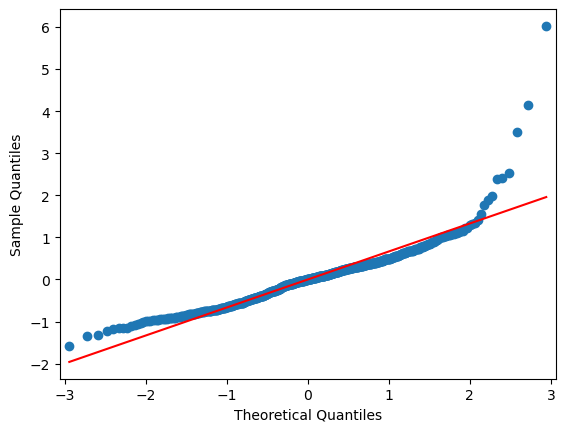

In [19]:
## QQ plots for normality assumptions
sm.qqplot(result.resid, line="s")

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p_value = sp.stats.shapiro(result.resid)
print(f"Shapiro-Wilk Test p-value: {shapiro_p_value}")

### Compare delta bump vs delta heading for all flies

### Plot every session

In [20]:
def get_ts(pp, coef = 0):
    y_epg = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)
    
    #shift heading so that bar not visible is pi/-pi
    heading = np.angle(np.exp(1j*(-1*pp.voltage_recording_aligned[' Heading'].to_numpy()-np.pi)))
    bar_vis_mask = np.abs(heading)<3*np.pi/4
   
    y_epg_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_epg-1, 1, axis=-1),.5,axis=1, mode='wrap')
    
    
    n_rois = y_epg.shape[1]
    
    # vector average
    x_f,y_f = st2p.utilities.pol2cart(y_epg[-1,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho_epg, phi_epg = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
    rho_epg, phi_epg = np.roll(rho_epg,-2), np.roll(phi_epg, -2)


    _,offset_epg = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_epg-heading))

    
    return {'heading': heading,
            'bar_vis_mask': bar_vis_mask,
            'y_epg': y_epg,
            'y_epg_sm': y_epg_sm,
            'rho_epg': rho_epg,
            'phi_epg': phi_epg,
            'offset_epg': offset_epg}


def align_to_heading(ts):
    
    # digitize heading to 16 discrete values
    heading_bins = np.linspace(-np.pi, np.pi, num=17)
    heading_dig = np.digitize(ts['heading'], heading_bins)-1 


    y_h_aligned = np.zeros([1,*ts['y_epg'].shape[1:]])
    for ind in range(ts['heading'].shape[0]):
        # circularly rotate rows to align heading
        y_h_aligned[-1,:,ind] = np.roll(ts['y_epg'][-1,:,ind], -heading_dig[ind]-8)
    
    return heading_bins, y_h_aligned

In [21]:
eg_folder = figfolder / 'example_sessions' 
eg_folder.mkdir(parents=True, exist_ok=True)

In [22]:
# plt.ioff() # turn off interactive plotting to prevent explosion of figures
plt.ion()
for i, (_, row) in enumerate(sess_df.iterrows()):
    
    outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] /  row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    
    ts = get_ts(pp,coef=0)
    
    bins = np.arange(16)
    dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
    
    
    fig, ax=plt.subplots(1,2, figsize=[30,3])
    plt.subplots_adjust(wspace=0)
    h = ax[0].imshow(ts['y_epg'][-1,:,:]-1,aspect='auto',cmap='Greys', 
                 vmin=np.percentile(ts['y_epg'][-1,:,:]-1,5), 
                 vmax=np.percentile(ts['y_epg'][-1,:,:]-1,95))
    plt.colorbar(h)
    _heading = 15*(ts['heading']+np.pi)/2/np.pi # put heading on plotting scale
    
    
    x = np.arange(_heading.shape[0]) # volume index
    t = np.arange(0,x[-1]*dt+1E-5,dt) # time
    time_to_index = sp.interpolate.interp1d(t,x, kind='linear') # look up function for plotting specific time values
    
    ax[0].scatter(x,_heading, color='red', s=4, alpha=.4) # overlay heading
    
    heading_bins, y_h_aligned = align_to_heading(ts) 
    h = ax[1].imshow(y_h_aligned[-1,:,:]-1, aspect='auto',cmap='Greys', 
                 vmin=np.percentile(ts['y_epg'][-1,:,:]-1,5), 
                 vmax=np.percentile(ts['y_epg'][-1,:,:]-1,95))
    
    plt.colorbar(h)
    
    # plot heading as a straight line
    ax[1].scatter(x,7.5*np.ones_like(x), color='red', s=4, alpha=.4) 
    
    
    # pretty up axes 
    time_ticks = np.arange(0,t[-1],30)
    ax[0].set_xticks(time_to_index(time_ticks),labels=[int(t) for t in time_ticks])
    ax[1].set_xticks(time_to_index(time_ticks),labels=[int(t) for t in time_ticks])
    for a in range(2):
        ax[a].set_yticks([r/2/np.pi*15 for r in (0,  np.pi/2,  np.pi,  6*np.pi/4,  2*np.pi)], 
                                                 labels = [r'-$\pi$',  r'-$\pi$/2',  '0',  r'$\pi$/2',  r'$\pi$'])
    ax[0].set_ylabel('EPG Wedge')
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    
    
    fig.suptitle(f"{row['fly_id']} {row['sess']}")
    fig.savefig(eg_folder / f"{row['fly_id']}_{row['sess']}_heading_centered.pdf")
    plt.close(fig)


    # plot histogram
    fig, ax = plt.subplots()
    edges = np.linspace(-np.pi,np.pi,num=16)
    centers = (edges[:-1]+edges[1:])/2
    hist, _ = np.histogram(ts['offset_epg'], bins = np.linspace(-np.pi,np.pi,num=16))
    ax.fill_between(edges[:-1], hist/hist.sum(), alpha=.4, color='black')
    ax.set_ylim([0,.25])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Offset')
    ax.set_ylabel('Prop.')
    offset_var = sp.stats.circvar(ts['offset_epg'])
    ax.set_title(f"offset variance = {offset_var}")
    fig.savefig(eg_folder / f"{row['fly_id']}_{row['sess']}_offset_histogram.pdf")
    plt.close(fig)

# plt.ion() # turn on interactive plotting



In [119]:
print()